In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sb

In [2]:
dir_fig = 'pca_calculation/'

In [3]:
file_cov = '/expanse/projects/sebat1/s3/data/sebat/long_reads_pipeline_results/coverages_mod.tsv'
#file_cov = '/tscc/projects/ps-sebat1/s3/data/sebat/long_reads_pipeline_results/coverages_mod.tsv'
df_cov = pd.read_table(file_cov, header=0, sep='\t')
multiplat_samples = ['REACH000236', 'REACH000530', 'REACH000531', 'REACH000532', 'REACH000436']
df_cov['SAMPLE'] = df_cov.apply(lambda row: row['SAMPLE']+'_'+row['COHORT'] if row['SAMPLE'] in multiplat_samples else row['SAMPLE'], axis=1)
df_cov_high = df_cov.loc[df_cov.SAMPLE.str.startswith('REACH000') & (df_cov.MEAN_COVERAGE > 9)]
display(df_cov)
high_cov_samples = df_cov_high.SAMPLE.tolist()
#print(high_cov_samples)

def get_plat(sample):
    try:
        ret = df_cov[df_cov.SAMPLE == sample]['COHORT'].values[0]
    except:
        print(f'problem with samples: {sample}')
        ret = ''
    return ret

plat_dict = {sample: get_plat(sample) for sample in df_cov.SAMPLE.tolist()}

,SAMPLE,COHORT,MEAN_COVERAGE
0,HG004,ONT,81.44
1,REACH000626,ONT,10.51
2,REACH000546,ONT,10.87
3,REACH000683,ONT,9.97
4,REACH000563,ONT,8.68
...,...,...,...
283,REACH000284,PB,3.43
284,REACH000672,PB,5.02
285,REACH000292,PB,9.00
286,REACH000066,PB,1.61


In [4]:
file_psam = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/process_IL_LR/HWE/REACH_LR_platform.psam'
df_p = pd.read_table(file_psam, sep='\t', header=None, names = ['famid', 'sample_id', 'dad', 'mom', 'sex', 'phen'])
display(df_p)

print('complete trios:')
df_trios = df_p.loc[df_p.dad.isin(df_p.sample_id) & df_p.mom.isin(df_p.sample_id)]
display(df_trios)
print(df_trios.sex.value_counts())
print(df_trios.phen.value_counts())

# make mom and dad dictionary
sample_dad_dict = {}
sample_mom_dict = {}
for sample, dad, mom in zip(df_trios.sample_id, df_trios.dad, df_trios.mom):
    #print(sample, dad, mom)
    sample_dad_dict[sample] = dad
    sample_mom_dict[sample] = mom

parents_set_lr = set(df_trios.dad.tolist()) | set(df_trios.mom.tolist())
#print(f'len(parents_set_lr): {len(parents_set_lr)}')
#print(parents_set_lr)

parents_set_pb = set([x for x in parents_set_lr if plat_dict[x]=='PB'])
parents_set_ont = set([x for x in parents_set_lr if plat_dict[x]=='ONT'])
#print('len(parents_set_pb):', len(parents_set_pb))
#print('len(parents_set_ont):', len(parents_set_ont))

parent_kids_dict = {}
mom_kids_dict = {}
dad_kids_dict = {}
for parent in parents_set_lr:
    parent_kids_dict[parent] = df_trios.loc[(df_trios.dad == parent) | (df_trios.mom == parent)].sample_id.tolist()
    if parent in df_trios.dad.tolist():
        dad_kids_dict[parent] = df_trios.loc[(df_trios.dad == parent)].sample_id.tolist()
    if parent in df_trios.mom.tolist():
        mom_kids_dict[parent] = df_trios.loc[(df_trios.mom == parent)].sample_id.tolist()
print(f'len(parent_kids_dict): {len(parent_kids_dict)}')
#print(parent_kids_dict)
print(f'len(mom_kids_dict): {len(mom_kids_dict)}')
#print(mom_kids_dict)
print(f'len(dad_kids_dict): {len(dad_kids_dict)}')
#print(dad_kids_dict)

mate_dict = {}
for dad, mom in zip(df_trios.dad, df_trios.mom):
    mate_dict[dad] = mom
    mate_dict[mom] = dad
print(f'len(mate_dict): {len(mate_dict)}')
#print(mate_dict)

,famid,sample_id,dad,mom,sex,phen
0,2323,2323-2-1,0,0,2,2
1,2602,2602-2-1,0,0,2,2
2,3392,3392-2-3,0,0,2,2
3,3538,3538-2-1,0,0,2,2
4,3939,3939-3-1,0,0,2,2
...,...,...,...,...,...,...
275,F0270,REACH000681,REACH000683,REACH000682,1,2
276,F0270,REACH000682,0,0,2,2
277,F0270,REACH000683,0,0,1,2
278,F0270,REACH000684,REACH000683,REACH000682,1,2


complete trios:


,famid,sample_id,dad,mom,sex,phen
10,F0026,REACH000026,REACH000270,REACH000269,1,2
11,F0058,REACH000058,REACH000440,REACH000439,1,2
12,F0065,REACH000065,REACH000067,REACH000066,1,2
15,F0078,REACH000086,REACH000088,REACH000087,1,2
18,F0078,REACH000089,REACH000088,REACH000087,2,2
...,...,...,...,...,...,...
271,F0266,REACH000660,REACH000662,REACH000661,2,2
274,F0266,REACH000663,REACH000662,REACH000661,1,1
275,F0270,REACH000681,REACH000683,REACH000682,1,2
278,F0270,REACH000684,REACH000683,REACH000682,1,2


sex
1    74
2    43
Name: count, dtype: int64
phen
2    92
1    25
Name: count, dtype: int64
len(parent_kids_dict): 126
len(mom_kids_dict): 63
len(dad_kids_dict): 63
len(mate_dict): 126


In [5]:
meta_file = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/REACH_sample_info.tsv'
df_meta = pd.read_table(meta_file, sep='\t', header=0)

rename_samples_dict = {'REACH000236': 'REACH000236_PB', 
                       'REACH000436': 'REACH000436_PB', 
                       'REACH000530': 'REACH000530_PB', 
                       'REACH000531': 'REACH000531_ONT', 
                       'REACH000532': 'REACH000532_ONT'}
df_meta['Sample_ID'] = df_meta.apply(lambda row: rename_samples_dict[row['Sample_ID']] 
                                     if row['Sample_ID'] in rename_samples_dict else row['Sample_ID'], axis=1)
display(df_meta)

aff_dict = {}
for sample, aff in zip(df_meta['Sample_ID'].tolist(), df_meta['Affected'].tolist()):
    aff_dict[sample] = aff 

,Sample_ID,Subject_ID,Family_ID,DOB,Family_Type,Affected,Diagnosis_LAB,Mother_ID,Father_ID,Rel_Proband,...,Date sent for DNA extraction,Location of DNA extraction,DNA Box,Concentration (ng/uL),260/280,Date sent for Sequencing,WGS Provider,(Sample Well) Plate Name.Sample.ID,Affected_orig,Affected_ASD
0,REACH000001,F0001-01,F0001,3/26/2007,trio,Yes,Autism,F0001-02,F0001-03,Proband,...,Unknown,Gleeson,1,60.0,1.80,9/9/2013,Illumina,LP6005688-DNA_E11,Yes,Yes
1,REACH000107,F0001-02,F0001,8/9/1972,trio,Yes,Autism,Unknown,Unknown,Mom,...,Unknown,Gleeson,2,60.0,NaN,9/9/2013,Illumina,LP6005688-DNA_F11,Yes,Yes
2,REACH000226,F0001-03,F0001,9/27/1969,trio,Yes,"Autism, PTSD, ADHD",Unknown,Unknown,Dad,...,Unknown,Gleeson,3,60.0,NaN,9/9/2013,Illumina,LP6005688-DNA_G11,Yes,Yes
3,REACH000002,F0002-01,F0002,11/19/2007,incomplete,Yes,Autism,Unknown,Unknown,Proband,...,Unknown,Gleeson,1,Incomplete,Incomplete,Incomplete family,Incomplete family,Incomplete family,Yes,Yes
4,REACH000003,F0003-01,F0003,8/9/2000,incomplete,Yes,Autism,Unknown,Unknown,Proband,...,Unknown,Gleeson,1,Incomplete,Incomplete,Incomplete family,Incomplete family,Incomplete family,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,REACH000889,F0320-02,F0320,1/15/1981,multiple,No,"Crohn's Disease, Lupus (SLE)",F8888-88,F8888-88,Mom,...,2/28/2017,Sebat,11,36.2,1.79,pending,pending,pending,No,No
889,REACH000890,F0320-03,F0320,7/9/1980,multiple,No,NaN,F8888-88,F8888-88,Dad,...,2/28/2017,Sebat,11,41.9,1.84,pending,pending,pending,No,No
890,REACH000891,F0320-04,F0320,2/26/2010,multiple,No,NaN,F0320-02,F0320-03,Sibling,...,2/28/2017,Sebat,11,119.7,1.84,pending,pending,pending,No,No
891,REACH000892,F0320-05,F0320,10/14/2011,multiple,No,NaN,F0320-02,F0320-03,Sibling,...,2/28/2017,Sebat,12,134.1,1.85,pending,pending,pending,No,No


In [7]:
#file_pca = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/PCA/kid_pca_info.csv'
#file_pca = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/PCA/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.20210915.csv'
file_pca = '/expanse/projects/sebat1/j3guevar/SFARI/aspera-sf/SFARI_DS468588/data/master_phen_4.SBayesR.20210915.csv'

df_pca = pd.read_table(file_pca, sep=',', header=0)
cols = ['fid', 'iid', 'phen','sex','cohort','duo','family','is_eur','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10', 
        'PC1_PAT','PC2_PAT','PC3_PAT','PC4_PAT','PC5_PAT','PC6_PAT','PC7_PAT','PC8_PAT','PC9_PAT','PC10_PAT', 
        'PC1_MAT','PC2_MAT','PC3_MAT','PC4_MAT','PC5_MAT','PC6_MAT','PC7_MAT','PC8_MAT','PC9_MAT','PC10_MAT']
df_pca = df_pca[cols]

rename_samples_dict = {'REACH000236': 'REACH000236_PB', 
                       'REACH000436': 'REACH000436_PB', 
                       'REACH000530': 'REACH000530_PB', 
                       'REACH000531': 'REACH000531_ONT', 
                       'REACH000532': 'REACH000532_ONT'}
df_pca['iid'] = df_pca.apply(lambda row: rename_samples_dict[row['iid']] if row['iid'] in rename_samples_dict else row['iid'], axis=1)
#display(df_pca)

# first filter for the kids, then add parents to them
df_pca_flt = df_pca.loc[df_pca.iid.isin(df_trios.sample_id)].copy()
df_pca_flt['rel'] = 'C'
print('df_pca_flt:')
display(df_pca_flt)

df_parents = pd.DataFrame()
for index, row in df_pca_flt.iterrows():
    sample = row['iid']
    fid = row['fid']
    phen = row['phen']
    is_eur = row['is_eur']
    pc_mat = [row[f'PC{x}_MAT'] for x in range(1,11)]
    pc_pat = [row[f'PC{x}_PAT'] for x in range(1,11)]
    dad = sample_dad_dict[sample]
    mom = sample_mom_dict[sample]
    
    dict_mat = {'fid': [fid], 'iid': [mom], 'phen': ['.'], 'sex': ['Female'], 'cohort': [1], 'duo': ['.'], 'is_eur': [is_eur]}
    dict_mat.update({f'PC{x}': [pc_mat[x-1]] for x in range(1,11)})
    df_mat = pd.DataFrame(dict_mat)

    dict_pat = {'fid': [fid], 'iid': [dad], 'phen': ['.'], 'sex': ['Male'], 'cohort': [1], 'duo': ['.'], 'is_eur': [is_eur]}
    dict_pat.update({f'PC{x}': [pc_pat[x-1]] for x in range(1,11)})
    df_pat = pd.DataFrame(dict_pat)
    
    if df_parents.shape[0] == 0 or mom not in df_parents.iid.tolist():
        df_parents = pd.concat([df_parents, df_mat])
    if df_parents.shape[0] == 0 or dad not in df_parents.iid.tolist():
        df_parents = pd.concat([df_parents, df_pat])

df_parents['rel'] = 'P'
print('df_parents:')
display(df_parents)

df_pca_flt = pd.concat([df_pca_flt, df_parents])
print('df_pca_flt:')
display(df_pca_flt)

df_pca_flt = pd.merge(df_pca_flt, df_meta[['Sample_ID', 'Affected', 'Affected_ASD']], how='inner', left_on='iid', right_on='Sample_ID')
df_pca_flt = pd.merge(df_pca_flt, df_cov[['SAMPLE', 'MEAN_COVERAGE']], how='inner', left_on='iid', right_on='SAMPLE')

df_pca_flt['Phenotype'] = df_pca_flt.apply(lambda row: 1 if row.Affected == 'Yes' else 0, axis=1)
df_pca_flt['Phenotype_ASD'] = df_pca_flt.apply(lambda row: 1 if row.Affected_ASD == 'Yes' else 0, axis=1)
df_pca_flt['Platform'] = df_pca_flt.apply(lambda row: get_plat(row.iid), axis=1)
#df_pca_flt.to_csv('investigate2.tsv', sep='\t', index=None)

df_pca_flt:


,fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,...,PC2_MAT,PC3_MAT,PC4_MAT,PC5_MAT,PC6_MAT,PC7_MAT,PC8_MAT,PC9_MAT,PC10_MAT,rel
136,F0001,REACH000001,ASD,Male,1,trio,1,1,0.008627,-0.005607,...,0.000410,0.002845,-0.019312,-0.013769,-0.014384,0.007249,0.002096,0.005399,-0.014983,C
137,F0026,REACH000026,ASD,Male,1,trio,1,0,0.095364,-0.045230,...,-0.047780,-0.017435,0.153686,0.005292,-0.009487,-0.020773,0.034190,0.015895,-0.011925,C
139,F0058,REACH000058,ASD,Male,1,trio,1,1,0.002422,-0.009216,...,-0.003289,0.003757,-0.004828,0.007650,0.005633,0.032103,0.009510,0.020007,0.016383,C
140,F0065,REACH000065,ASD,Male,1,trio,1,0,0.252774,0.107933,...,0.049799,0.158347,0.011411,0.004728,0.007690,-0.006605,0.008261,-0.012000,-0.009906,C
146,F0078,REACH000086,ASD,Male,1,trio,2,0,0.044785,0.038065,...,0.080387,0.132056,0.029583,0.020156,0.007971,-0.002383,0.014468,0.006253,-0.018303,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,F0290,REACH000762,ASD,Male,1,trio,1,1,-0.027901,0.000946,...,0.003052,-0.009075,-0.014136,-0.005499,-0.008555,0.015644,0.004869,0.011004,-0.019684,C
409,F0290,REACH000765,CON,Female,1,trio,1,1,-0.030809,-0.001867,...,0.003052,-0.009075,-0.014136,-0.005499,-0.008555,0.015644,0.004869,0.011004,-0.019684,C
410,F0290,REACH000766,CON,Female,1,trio,1,1,-0.028469,-0.005167,...,0.003052,-0.009075,-0.014136,-0.005499,-0.008555,0.015644,0.004869,0.011004,-0.019684,C
411,F0291,REACH000767,ASD,Male,1,trio,1,0,0.087690,-0.012273,...,-0.016917,-0.021358,0.151522,-0.035297,0.008383,0.005679,0.020179,-0.022316,0.002755,C


df_parents:


,fid,iid,phen,sex,cohort,duo,is_eur,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,rel
0,F0001,REACH000107,.,Female,1,.,1,-0.022403,0.000410,0.002845,-0.019312,-0.013769,-0.014384,0.007249,0.002096,0.005399,-0.014983,P
0,F0001,REACH000226,.,Male,1,.,1,0.024023,-0.013482,-0.003936,0.129597,0.030587,-0.007727,-0.002212,-0.022159,0.005150,-0.000824,P
0,F0026,REACH000269,.,Female,1,.,0,0.100551,-0.047780,-0.017435,0.153686,0.005292,-0.009487,-0.020773,0.034190,0.015895,-0.011925,P
0,F0026,REACH000270,.,Male,1,.,0,0.091671,-0.037847,-0.022134,0.163193,0.007864,-0.006841,-0.023716,0.040800,0.006666,-0.012916,P
0,F0058,REACH000439,.,Female,1,.,1,-0.025327,-0.003289,0.003757,-0.004828,0.007650,0.005633,0.032103,0.009510,0.020007,0.016383,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,F0288,REACH000756,.,Male,1,.,0,0.204041,0.127559,0.190286,0.013553,0.006706,-0.001266,-0.010150,0.006605,-0.006867,0.006560,P
0,F0290,REACH000763,.,Female,1,.,1,-0.030630,0.003052,-0.009075,-0.014136,-0.005499,-0.008555,0.015644,0.004869,0.011004,-0.019684,P
0,F0290,REACH000764,.,Male,1,.,1,-0.027327,-0.004878,-0.003881,0.000495,0.003727,-0.001647,-0.008831,0.016730,-0.005315,0.006958,P
0,F0291,REACH000768,.,Female,1,.,0,0.091442,-0.016917,-0.021358,0.151522,-0.035297,0.008383,0.005679,0.020179,-0.022316,0.002755,P


df_pca_flt:


,fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,...,PC2_MAT,PC3_MAT,PC4_MAT,PC5_MAT,PC6_MAT,PC7_MAT,PC8_MAT,PC9_MAT,PC10_MAT,rel
136,F0001,REACH000001,ASD,Male,1,trio,1.0,1,0.008627,-0.005607,...,0.000410,0.002845,-0.019312,-0.013769,-0.014384,0.007249,0.002096,0.005399,-0.014983,C
137,F0026,REACH000026,ASD,Male,1,trio,1.0,0,0.095364,-0.045230,...,-0.047780,-0.017435,0.153686,0.005292,-0.009487,-0.020773,0.034190,0.015895,-0.011925,C
139,F0058,REACH000058,ASD,Male,1,trio,1.0,1,0.002422,-0.009216,...,-0.003289,0.003757,-0.004828,0.007650,0.005633,0.032103,0.009510,0.020007,0.016383,C
140,F0065,REACH000065,ASD,Male,1,trio,1.0,0,0.252774,0.107933,...,0.049799,0.158347,0.011411,0.004728,0.007690,-0.006605,0.008261,-0.012000,-0.009906,C
146,F0078,REACH000086,ASD,Male,1,trio,2.0,0,0.044785,0.038065,...,0.080387,0.132056,0.029583,0.020156,0.007971,-0.002383,0.014468,0.006253,-0.018303,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,F0288,REACH000756,.,Male,1,.,NaN,0,0.204041,0.127559,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P
0,F0290,REACH000763,.,Female,1,.,NaN,1,-0.030630,0.003052,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P
0,F0290,REACH000764,.,Male,1,.,NaN,1,-0.027327,-0.004878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P
0,F0291,REACH000768,.,Female,1,.,NaN,0,0.091442,-0.016917,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P


In [8]:
#########################################
file_name = 'test.tsv'
df = pd.read_table(file_name, sep='\t', header=0, keep_default_na=False)

/scratch/smmortazavi/job_34067971/ipykernel_3862487/3898870177.py:3: DtypeWarning: Columns (24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(file_name, sep='\t', header=0, keep_default_na=False)


In [12]:
sample_order = df_pca_flt.iid.tolist()
#print(len(sample_order))
#print(sample_order)

def get_gt_col(row, col):
    samples = [x.split(':')[0] for x in row[col].split(',') if x.split(':')[0] in sample_order]
    ret_col = [0 for sample in sample_order]
    for sample in samples:
        idx = sample_order.index(sample)
        ret_col[idx] = 1
    return ret_col

lzs_thrs = [3]
supp_thrs = [2, 3]

++++++++++++++++++++++++++++++++++++++++
ZS: 3, SUPP: 2
pca_calculation/PC1_vs_PC2_ZS3_SUPP2.png


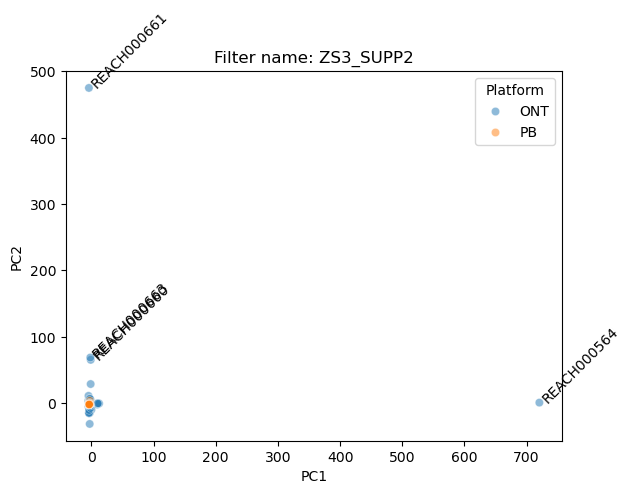

++++++++++++++++++++++++++++++++++++++++
ZS: 3, SUPP: 3
pca_calculation/PC1_vs_PC2_ZS3_SUPP3.png


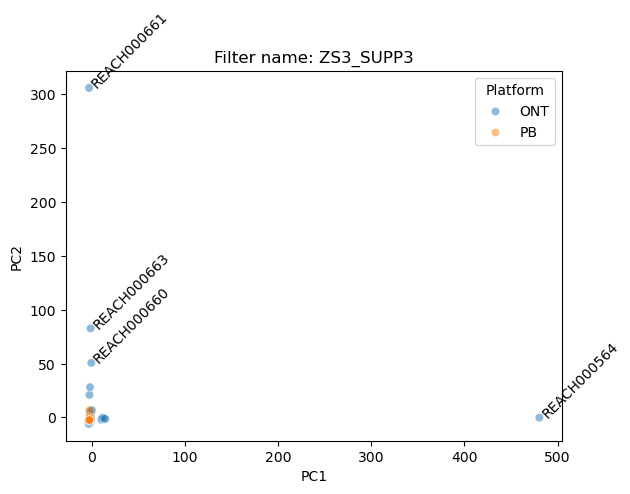

df_pca_all:


,PC1_ZS3_SUPP2,PC2_ZS3_SUPP2,PC3_ZS3_SUPP2,PC4_ZS3_SUPP2,PC5_ZS3_SUPP2,PC6_ZS3_SUPP2,PC7_ZS3_SUPP2,PC8_ZS3_SUPP2,PC9_ZS3_SUPP2,PC10_ZS3_SUPP2,...,PC1_ZS3_SUPP3,PC2_ZS3_SUPP3,PC3_ZS3_SUPP3,PC4_ZS3_SUPP3,PC5_ZS3_SUPP3,PC6_ZS3_SUPP3,PC7_ZS3_SUPP3,PC8_ZS3_SUPP3,PC9_ZS3_SUPP3,PC10_ZS3_SUPP3
0,-3.115974,-13.249071,-2.390886,-6.210402,-19.791958,-63.534924,-104.388380,339.421082,186.829228,4.733852,...,-1.782263,-3.205129,-3.323966,-2.214985,0.322870,9.721992,-10.535263,-18.349284,70.626088,51.619410
1,-3.548548,-2.321519,-2.160340,-0.156222,-2.502294,-0.546473,-1.421091,-2.074841,-0.243738,0.428895,...,-2.370984,-2.347220,-2.145633,-2.376730,-1.275994,-1.896649,-2.070697,-2.071524,-0.878803,-1.701440
2,-3.170343,-2.713150,-2.457797,-0.406842,-2.610085,-0.862311,-1.802877,-1.944123,0.584564,0.910535,...,-2.327518,-3.007499,-2.338635,-3.132996,-2.451309,0.970024,-2.097239,-1.690270,-0.675318,-0.547657
3,-3.529721,-2.342296,-2.186234,-0.133619,-2.505011,-0.510788,-1.469200,-1.978723,-0.327371,0.498103,...,-2.350961,-2.361969,-2.125702,-2.409910,-1.238475,-1.837641,-2.032078,-2.039455,-0.699047,-1.560543
4,-3.487373,-2.421050,-2.012187,-0.133010,-2.431247,-0.261128,-1.382320,-1.711111,0.138007,0.227427,...,-2.253725,-2.483840,-1.931278,-2.358981,-1.227516,-0.822100,-2.152448,-1.872460,-1.448851,-1.292145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,-3.274204,-2.334866,-2.004205,-0.165000,-2.337901,-0.427802,-1.294823,-1.669227,-0.465839,0.422229,...,-2.379141,-2.494387,-1.911129,-2.220915,-1.209903,-1.971397,-2.063156,-1.731883,-1.106025,-1.642758
239,-3.376738,-2.310491,-1.888703,-0.287367,-2.079686,-0.473951,-1.132848,-2.009159,-0.159340,0.950320,...,-2.091711,-2.103574,-2.049129,-2.536720,-1.300378,-1.774070,-1.462282,-1.710964,-1.055191,-1.351450
240,-3.543449,-2.274492,-2.166835,-0.147174,-2.473078,-0.434487,-1.462645,-2.000985,-0.233998,0.481855,...,-2.311716,-2.308404,-2.120857,-2.389182,-1.325652,-1.705381,-1.825346,-2.084209,-0.697060,-1.744439
241,-3.513765,-2.417478,-2.159116,-0.127717,-2.458276,-0.504105,-1.436524,-2.005755,-0.255579,0.521624,...,-2.341181,-2.472315,-2.101828,-2.385515,-1.281947,-1.842227,-1.989746,-1.999737,-0.826159,-1.703112


df_var_explained:


,explained_variance_ratio_ZS3_SUPP2,explained_variance_ratio_ZS3_SUPP3
0,0.034594,0.040749
1,0.015901,0.018603
2,0.015605,0.017262
3,0.014122,0.016812
4,0.013968,0.014620
5,0.012733,0.012915
6,0.012540,0.012649
7,0.012472,0.011781
8,0.012360,0.011461
9,0.012081,0.011267


pca_calculation/PC_data.tsv
pca_calculation/var_explained_data.tsv


In [15]:
### write PCA components for TRs
df_pca_all = pd.DataFrame()
df_var_explained = pd.DataFrame()
for lzs_thr in lzs_thrs:
    for supp_thr in supp_thrs:
        print('+'*40)
        print(f'ZS: {lzs_thr}, SUPP: {supp_thr}')
        label = f'ZS{lzs_thr}_SUPP{supp_thr}'
        samples_col = f'LZS{lzs_thr}_SAMPLES_SUPP{supp_thr}_Q'
        # make the full matrix of sample x genotypes
        X = df.apply(lambda row: get_gt_col(row, samples_col), axis=1, result_type='expand').T
        X.index = sample_order
        #print(X.shape)
        #display(X)

        # calculate PCA dim reduction with 10 components
        scaler = StandardScaler()
        X_standardized = scaler.fit_transform(X)
        pca = PCA(n_components=10)
        principal_components = pca.fit_transform(X_standardized)
        df_pca = pd.DataFrame(data=principal_components, columns=[f'PC{i}_{label}' for i in range(1,11,1)])
        #display(df_pca)
        if df_pca_all.empty:
            df_pca_all = pd.DataFrame(df_pca)
        else:
            df_pca_all = pd.concat([df_pca_all, df_pca], axis=1)
        df_var_explained[f'explained_variance_ratio_{label}'] = pca.explained_variance_ratio_
        #print(pca.explained_variance_ratio_)
    
        # add platform
        df_pca_all['Platform'] = df_pca_flt['Platform']
        df_pca_all['SAMPLE'] = sample_order

        pc1_thr = 40
        pc2_thr = 40
        plt.figure()
        sb.scatterplot(data=df_pca_all, x=f'PC1_{label}', y=f'PC2_{label}', hue='Platform', alpha=.5)
        for pc1, pc2, s in zip(df_pca_all[f'PC1_{label}'], df_pca_all[f'PC2_{label}'], df_pca_all['SAMPLE']):
            if pc1 >= pc1_thr or pc2 >= pc2_thr:
                plt.text(pc1, pc2, s, rotation=45)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title(f'Filter name: {label}')
        fig_name = dir_fig + f'PC1_vs_PC2_{label}.png'
        print(fig_name)
        plt.savefig(fig_name, bbox_inches='tight')
        #plt.plot(df_pca.PC1, df_pca.PC2, 'o')
        plt.show()

print('df_pca_all:')
display(df_pca_all)
print('df_var_explained:')
display(df_var_explained)

file_name = dir_fig + f'PC_data.tsv'
print(file_name)
df_pca_all.to_csv(file_name, sep='\t', index=False)

file_name = dir_fig + f'var_explained_data.tsv'
print(file_name)
df_var_explained.to_csv(file_name, sep='\t', index=False)

++++++++++++++++++++++++++++++++++++++++
ZS: 3, SUPP: 3
pca_calculation/PC1_vs_PC2_ZS3_SUPP3.png


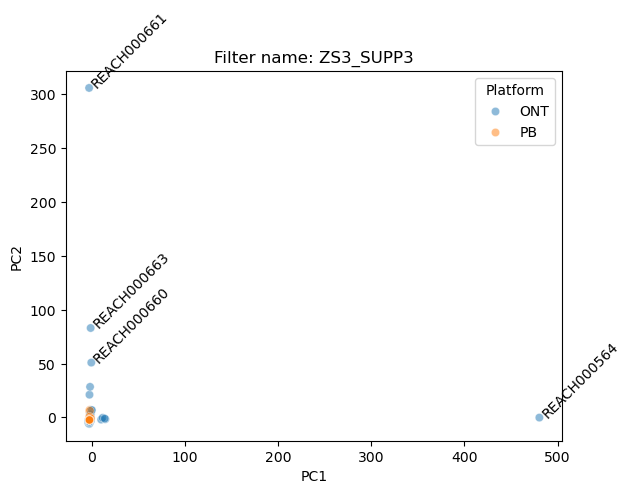

pca_calculation/PC2_vs_PC3_ZS3_SUPP3.png


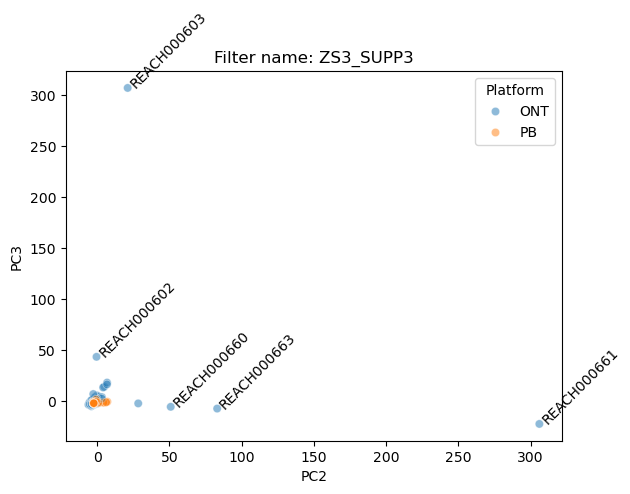

pca_calculation/PC3_vs_PC4_ZS3_SUPP3.png


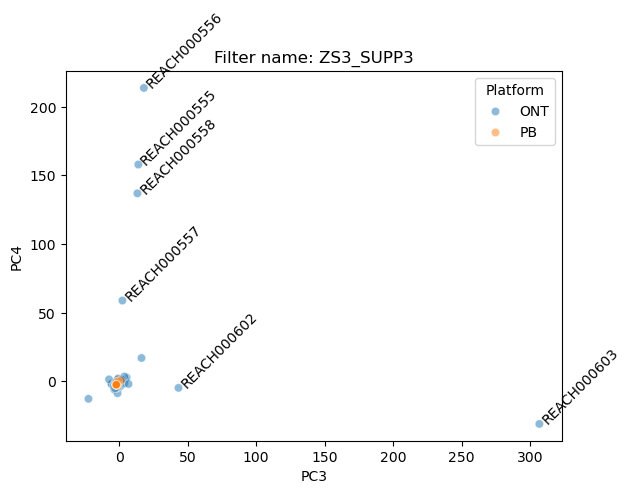

pca_calculation/PC4_vs_PC5_ZS3_SUPP3.png


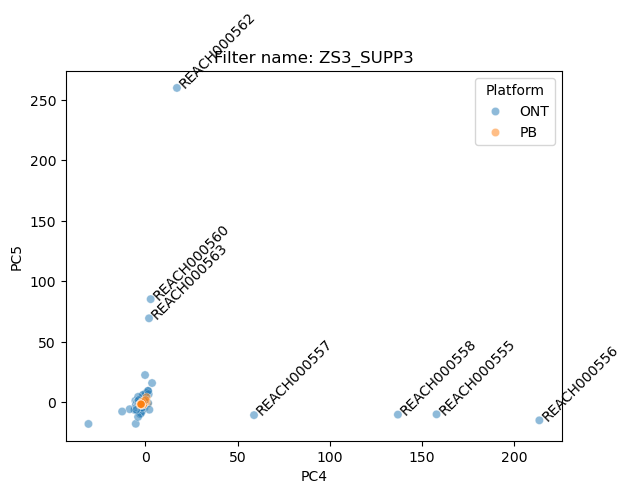

pca_calculation/PC5_vs_PC6_ZS3_SUPP3.png


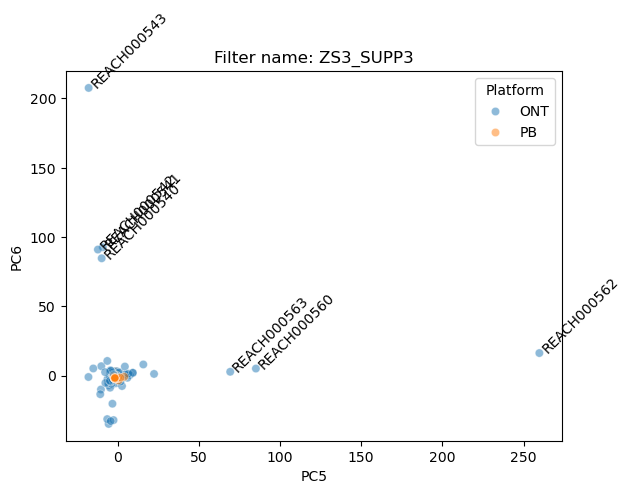

pca_calculation/PC6_vs_PC7_ZS3_SUPP3.png


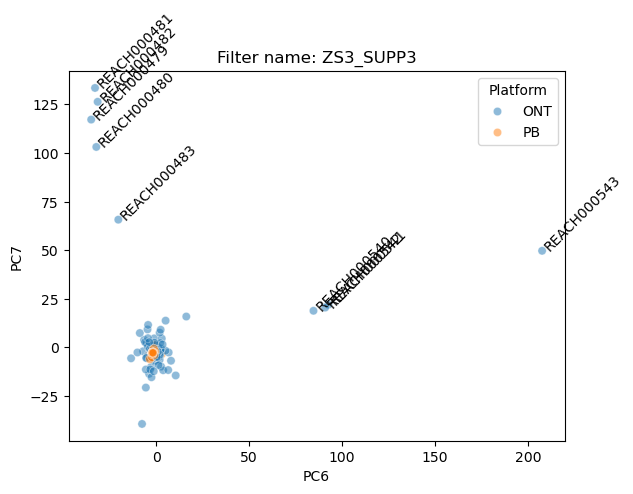

pca_calculation/PC7_vs_PC8_ZS3_SUPP3.png


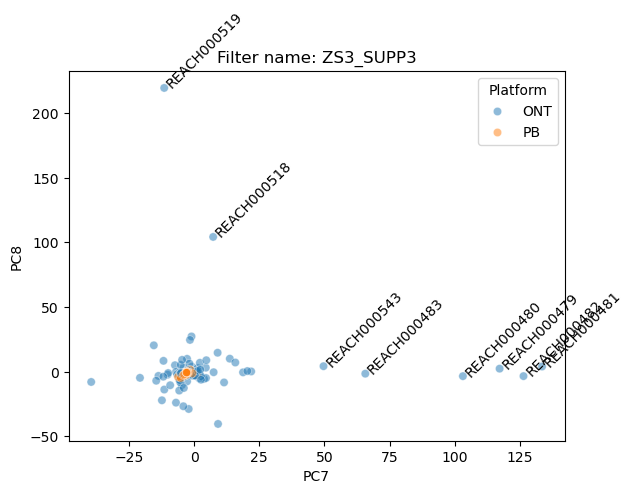

pca_calculation/PC8_vs_PC9_ZS3_SUPP3.png


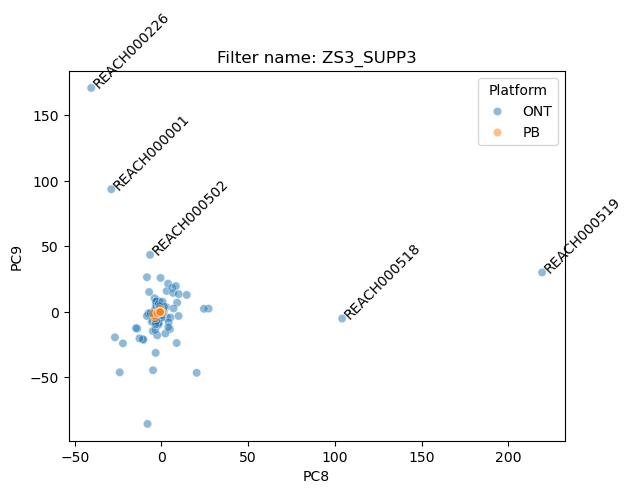

pca_calculation/PC9_vs_PC10_ZS3_SUPP3.png


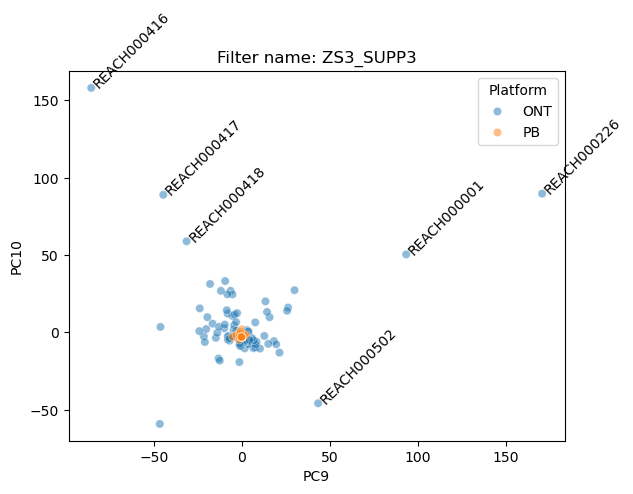

In [16]:
### plot all PC plots
df_pca_all = pd.DataFrame()
df_var_explained = pd.DataFrame()
for lzs_thr in lzs_thrs:
    for supp_thr in supp_thrs[-1:]:
        print('+'*40)
        print(f'ZS: {lzs_thr}, SUPP: {supp_thr}')
        label = f'ZS{lzs_thr}_SUPP{supp_thr}'
        samples_col = f'LZS{lzs_thr}_SAMPLES_SUPP{supp_thr}_Q'
        # make the full matrix of sample x genotypes
        X = df.apply(lambda row: get_gt_col(row, samples_col), axis=1, result_type='expand').T
        X.index = sample_order
        #print(X.shape)
        #display(X)

        # calculate PCA dim reduction with 10 components
        scaler = StandardScaler()
        X_standardized = scaler.fit_transform(X)
        pca = PCA(n_components=10)
        principal_components = pca.fit_transform(X_standardized)
        df_pca = pd.DataFrame(data=principal_components, columns=[f'PC{i}_{label}' for i in range(1,11,1)])
        #display(df_pca)
        if df_pca_all.empty:
            df_pca_all = pd.DataFrame(df_pca)
        else:
            df_pca_all = pd.concat([df_pca_all, df_pca], axis=1)
        df_var_explained[f'explained_variance_ratio_{label}'] = pca.explained_variance_ratio_
        #print(pca.explained_variance_ratio_)
    
        # add platform
        df_pca_all['Platform'] = df_pca_flt['Platform']
        df_pca_all['SAMPLE'] = sample_order

        pc1_thr = 40
        pc2_thr = 40
        plt.figure()
        sb.scatterplot(data=df_pca_all, x=f'PC1_{label}', y=f'PC2_{label}', hue='Platform', alpha=.5)
        for pc1, pc2, s in zip(df_pca_all[f'PC1_{label}'], df_pca_all[f'PC2_{label}'], df_pca_all['SAMPLE']):
            if pc1 >= pc1_thr or pc2 >= pc2_thr:
                plt.text(pc1, pc2, s, rotation=45)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title(f'Filter name: {label}')
        fig_name = dir_fig + f'PC1_vs_PC2_{label}.png'
        print(fig_name)
        plt.savefig(fig_name, bbox_inches='tight')
        #plt.plot(df_pca.PC1, df_pca.PC2, 'o')
        plt.show()
        
        pc1_thr = 40
        pc2_thr = 40
        for i_pc in range(2, 10 ,1):
            plt.figure()
            sb.scatterplot(data=df_pca_all, x=f'PC{i_pc}_{label}', y=f'PC{i_pc+1}_{label}', hue='Platform', alpha=.5)
            for pc1, pc2, s in zip(df_pca_all[f'PC{i_pc}_{label}'], df_pca_all[f'PC{i_pc+1}_{label}'], df_pca_all['SAMPLE']):
                if pc1 >= pc1_thr or pc2 >= pc2_thr:
                    plt.text(pc1, pc2, s, rotation=45)
            plt.xlabel(f'PC{i_pc}')
            plt.ylabel(f'PC{i_pc+1}')
            plt.title(f'Filter name: {label}')
            fig_name = dir_fig + f'PC{i_pc}_vs_PC{i_pc+1}_{label}.png'
            print(fig_name)
            plt.savefig(fig_name, bbox_inches='tight')
            #plt.plot(df_pca.PC1, df_pca.PC2, 'o')
            plt.show()

#print('df_pca_all:')
#display(df_pca_all)
#print('df_var_explained:')
#display(df_var_explained)

#file_name = dir_fig + f'PC_data.tsv'
#print(file_name)
#df_pca_all.to_csv(file_name, sep='\t', index=False)

#file_name = dir_fig + f'var_explained_data.tsv'
#print(file_name)
#df_var_explained.to_csv(file_name, sep='\t', index=False)